In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/StableManipulation/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Plots
using Convex, SCS
using JLD
using StableManipulation

In [3]:
include("../models/rod_corner_frictionless.jl")

Main.RodWorld

In [4]:
dynamics! = RodWorld.ode_dynamics!
conditions = RodWorld.ode_conditions
affect! = RodWorld.ode_affect!
affect_neg! = RodWorld.ode_affect_neg!

domain = RodWorld.domain
guard_set = RodWorld.guard_set
jumpmap = RodWorld.jumpmap

n_contacts = RodWorld.n_contacts
Δt = RodWorld.Δt
modes = RodWorld.modes

tol_c = RodWorld.tol_c


1.0e-5

In [5]:
function no_controller(x, contactMode)
    return zeros(3)
end

no_controller (generic function with 1 method)

In [6]:
# goal: hold the rod at 45 degrees at the corner
xref = [cos(pi/4)*RodWorld.l/2; sin(pi/4)*RodWorld.l/2; pi/4; 0; 0; 0]

nominal_mode = [true, true]

function wrench_control_2_body(x, control_u)
    u = [control_u[1]; control_u[2]; 
        control_u[3] - control_u[1]*sin(x[3])*RodWorld.l/2 + control_u[2]*cos(x[3])*RodWorld.l/2]
    return u
end

function control_discrete_dynamics(x, control_u, mode)
    u = wrench_control_2_body(x,control_u)
    xn = RodWorld.discrete_dynamics(x, u, mode)
    return xn
end

function control_dynamics(x, control_u, mode)
    u = wrench_control_2_body(x,control_u)
    dx = RodWorld.continuous_dynamics_differentiable(x, u, mode)
    return dx
end

control_u_ref = [-RodWorld.m*RodWorld.g*cot(pi/4)/2; 0; 0]

3-element Vector{Float64}:
 -4.900000000000001
  0.0
  0.0

In [7]:
function ref_controller(x, contactMode)
    f = wrench_control_2_body(x, control_u_ref)
    #f = [0;RodWorld.m*RodWorld.g;0]
    return f
end

ref_controller (generic function with 1 method)

# LQR

In [8]:
# LQR controller
# compute infinite horizon K
A_lqr = ForwardDiff.jacobian(_x->control_discrete_dynamics(_x, control_u_ref, nominal_mode), xref)
B_lqr = ForwardDiff.jacobian(_u->control_discrete_dynamics(xref, _u, nominal_mode), control_u_ref)
# Q_lqr = Diagonal([1.0; 1.0; 1.0; 0.5; 0.5; 0.5])
Q_lqr = Diagonal([1.0; 1.0; 1.0; 0.5; 0.5; 0.5])
R_lqr = Diagonal([0.1; 0.1; 0.1])

Ks, _ = StableManipulation.riccati(A_lqr,B_lqr,Q_lqr,R_lqr,Q_lqr,50)
K_lqr = Ks[1]

function lqr_controller(x, contactMode)
    control_u = control_u_ref .- K_lqr*(x .- xref)
    f = wrench_control_2_body(x,control_u)
    return f
end


lqr_controller (generic function with 1 method)

In [9]:
K_lqr

3×6 Matrix{Float64}:
  0.206036  -0.206036  -4.42748   0.124395  -0.124395  -1.20322
 -0.206036   0.206036   4.42748  -0.124395   0.124395   1.20322
 -0.291379   0.291379   6.26141  -0.175921   0.175921   1.70161

# Hybrid Controller

In [10]:
# Lyapunov function
function V(x)
    q = x[1:3] + x[4:6]
    dq = x[4:6]

    v = 0.5*([q;dq] .- xref)'*Q_lqr*([q;dq] .- xref)

    return v
end 

function dVdx(x)
    res = ForwardDiff.gradient(V, x)
    return res
end

dVdx (generic function with 1 method)

In [11]:
# problem specific numbers

const n_modes = size(modes, 1)

const n_u = 3
const n_β = 50
const n_α = 2*n_modes - 1

function hybrid_constraints_matrix(x, u_ref)


    n = n_u + n_β + n_α
    m = 2*n_modes - 1

    A = zeros(m, n)
    b = zeros(m)

    nominal_mode = [true, true]

    β_idx = 1

    Vx = dVdx(x)
    Vv = V(x)

    # mode dynamics
    
    for k = 1:n_modes

        m = modes[k,:]
        
        d_ineq, d_eq = domain(x, m)
        
        # TODO: debug this!!!
        # if sum(d_ineq.<0)>0 || sum(abs.(d_eq) .> tol_c)>0
        #     b[k] = 0.1
        #     continue
        # end
        
        n_ineq = size(d_ineq, 1)
        n_eq = size(d_eq, 1)
        
        dfdu = ForwardDiff.jacobian(_u->control_dynamics(x, _u, m), u_ref)
        
        b[k] = -Vx'*control_dynamics(x, u_ref, m)
        
        # α
        A[k, n_u+n_β+k] = -Vv
        A[k, 1:n_u] = -Vx'*dfdu
        A[k, β_idx:β_idx+n_ineq-1] .= -d_ineq
        A[k, β_idx+n_ineq:β_idx+n_ineq+n_eq-1] .= -d_eq 
        A[k, β_idx+n_ineq+n_eq:β_idx+n_ineq+2*n_eq-1] .= d_eq 
        
        β_idx += n_ineq + 2*n_eq
        
    end
        
    # TODO: nominal_mode isn't always the last mode
    k = 1
    for k_ = 1:n_modes
        
        mode_from = modes[k,:]

        if StableManipulation.is_same_mode(mode_from, nominal_mode)
            continue
        end
        
        d_ineq, d_eq = guard_set(x, mode_from, nominal_mode)
        
        # if sum(d_ineq.<0)>0 || sum(abs.(d_eq) .> tol_c)>0
        #     b[k] = 0.1
        #     continue
        # end
        
        n_ineq = size(d_ineq, 1)
        n_eq = size(d_eq, 1)
        
        xp = jumpmap(x, mode_from, nominal_mode)
        
        dfdu = ForwardDiff.jacobian(_u->control_dynamics(xp, _u, nominal_mode), u_ref)
        
        b[n_modes+k] = -Vx'*control_dynamics(xp, u_ref, nominal_mode)
        A[k, n_u+n_β+n_modes+k] = -Vv
        A[n_modes+k, 1:n_u] = -Vx'*dfdu
        A[n_modes+k, β_idx:β_idx+n_ineq-1] .= -d_ineq
        A[n_modes+k, β_idx+n_ineq:β_idx+n_ineq+n_eq-1] .= -d_eq 
        A[n_modes+k, β_idx+n_ineq+n_eq:β_idx+n_ineq+2*n_eq-1] .= d_eq 
        
        β_idx += n_ineq + 2*n_eq
        k += 1
        
    end
    
    return A, b

end


hybrid_constraints_matrix (generic function with 1 method)

In [12]:
# use LQR as the reference for the hybrid controller
function hybrid_controller_reference(x, contactMode)
    control_u = control_u_ref .- K_lqr*(x .- xref)
    return control_u
end 

hybrid_controller_reference (generic function with 1 method)

In [13]:
function hybrid_controller(x, contactMode)
    
    u_ref = hybrid_controller_reference(x, contactMode) # from reference controller
    
    α_ref = 15

    n_var = n_u + n_β + n_α

    z = Variable(n_var)
    A, b = hybrid_constraints_matrix(x, u_ref)
    
    problem = minimize(sumsquares(z - [zeros(n_u + n_β); α_ref*ones(n_α)]))
    problem.constraints += A*z + b >= 0
    problem.constraints += z[n_u+1:end] >= 0
    # problem.constraints += z[1:n_u] <= 10
    # problem.constraints += z[1:n_u] >= -10

    Convex.solve!(problem, () -> SCS.Optimizer(verbose=false))
    
    z_sol = evaluate(z)
    if any(isnan.(z_sol)) || sum(z_sol) == Inf # infeasible
        z_sol = zeros(n_var)
#         println("Infeasible: ")
#         println(x)
#         println(contactMode)
    end
    
    u = z_sol[1:n_u] .+ u_ref
    
    # return space wrench
    f = wrench_control_2_body(x, u)
    
    return f
    
end

hybrid_controller (generic function with 1 method)

In [14]:
hybrid_controller(xref, [true, true])

3-element Vector{Float64}:
 -4.900000000000001
  0.0
  1.7324116139070418

In [56]:
controller = hybrid_controller

x0 = xref .+  [0.5;0.5;0.1;0;0;0]
initial_mode = [false, false]

tspan = (0.0, 1.5)
callback_length = 2*RodWorld.n_contacts

h_control = RodWorld.Δt

prob = ODEProblem(dynamics!, x0, tspan, (initial_mode, controller, [0.0], h_control, controller(x0, initial_mode)))
cb = VectorContinuousCallback(conditions, affect!, affect_neg!, callback_length)
sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15, adaptive=false,dt=RodWorld.Δt/10)
# sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15)
println("Simulation status: ", sol.retcode)

New mode from IV: Bool[0, 1]
[0.6567327789203578, 0.40666361466307427, 0.9498482574095992, -1.3327791019294997, -1.1451430765445256, -3.9365082784673637]
New mode from IV: Bool[1, 1]
[0.37862515287011517, 0.32656627153974543, 0.7117036096403838, -0.5761101727398446, 0.6679575170723774, 1.7641657243556559]
Simulation status: 

Success


In [57]:
n

306

┌ Info: Saved animation to 
│   fn = /Users/xianyi/.julia/dev/StableManipulation/example/anim.gif
└ @ Plots /Users/xianyi/.julia/packages/Plots/YAlrZ/src/animation.jl:114


Plots.AnimatedGif("/Users/xianyi/.julia/dev/StableManipulation/example/anim.gif")
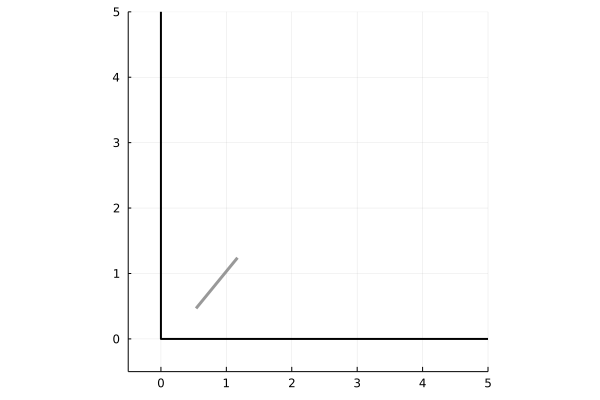

In [58]:
n = length(sol.t)
interval_n = 10
# n = Int(floor(0.77/Δt))
x = zeros(Int(floor(n/interval_n))+1)
y = zeros(Int(floor(n/interval_n))+1)
θ = zeros(Int(floor(n/interval_n))+1)
for i = 1:interval_n:n
    k = Int(floor(i/interval_n)+1)
    x[k] = sol.u[i][1]
    y[k] = sol.u[i][2]
    θ[k] = sol.u[i][3]
end

RodWorld.animation(x,y,θ,Int(floor(n/10))+1)

Both LQR and Hybrid controllers work well for this example. 
When you have issues of the object flying around, decrease simulation step size.